# Assignment 2: Mining Itemsets (Part I)


Starting from this week, you will get your hands wet by playing with real-world data with your freshly learned data mining techniques.  To test your understanding of the concepts, you will be asked to implement some of these techniques by your own, for which you can only call from a restricted set of APIs.  In your own projects, of course, you are encouraged to use as many packages and APIs as you may. 

For this assignment, we sampled 10 thousand Tweets with two or more food/drink emojis (yes, those colorful tasty ideograms). You will represent this dataset as a collection of itemsets and practice what we learned in class -- mining and evaluating frequent itemsets, and calculating the similarity of itemsets. 

**Disclaimer**: The data are collected from the real world. As you step into the *wild*, things might not always be nice and clean. Although we, the instructing team, have tried our best effort to filter out Tweets containing poisonous vocabularies and links. It is still possible that you will encouter offensive contents. 

In this assignment, you will:

- Represent the dataset as a collection of itemsets and mine frequent patterns from it.
- Get familiar with a set of metrics for measuring the importance of patterns (support, frequency, lift, chi-square, mutual information).
- Calculate Jaccard similarity and find the top $k$ similar itemsets to a given itemset.
- Understand Apriori and implement a part of the algorithm.

Have fun and cheers!🍻

Now Part I begins. We will represent the dataset as a collection of itemsets and conduct some descriptive analysis. The purpose is to get you familiar with the data. You do not need to change any of the code blocks, but just execute all of them and examine the output. Please read through the text descriptions and the code blocks carefully. After you are done, feel free to further explore the dataset in your own ways. 

First, let's import the packages and dependencies that will be used later.

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Preprocessing

Let's start by loading the dataset and preview its first few lines

In [9]:
tweets_df = pd.read_csv("assets/food_drink_emoji_tweets.txt", sep="\t", header=None)
tweets_df.columns = ['text']
tweets_df.head()

,text
0,RT @CalorieFixess: 🍗🌯🍔🍒 400 Calories https://t...
1,RT @1_F_I_R_S_T: _ 🍈¹〉Grow your account fast! ...
2,RT @LegendDeols: 👉👉👉G€T Ready to dance💃🕺🕺🕺💃💃💃 ...
3,@britch_x Hubby's friend bought us Wendy's-che...
4,RT @DAILYPUPPlES: Workout partner ☕🍌😍 https://...


You should find that every line of the data is a Tweet. Now let's extract the emojis that appear in each Tweet as an itemset. For this assignment, we are only interested in emojis that are food and drink.

In [10]:
emoji_by_category = {
    "food_fruit": "🍇🍈🍉🍊🍋🍌🍍🥭🍎🍏🍐🍑🍒🍓🥝🍅🥥",
    "food_vegetable": "🥑🍆🥔🥕🌽🌶🥒🥬🥦🍄🥜🌰",
    "food_prepared": "🍞🥐🥖🥨🥯🥞🧀🍖🍗🥩🥓🍔🍟🍕🌭🥪🌮🌯🥙🥚🍳🥘🍲🥣🥗🍿🧂🥫",
    "food_asian": "🍱🍘🍙🍚🍛🍜🍝🍠🍢🍣🍤🍥🥮🍡🥟🥠🥡",
    "food_marian": "🦀🦞🦐🦑",
    "food_sweet": "🍦🍧🍨🍩🍪🎂🍰🧁🥧🍫🍬🍭🍮🍯",
    "drink": "🍼🥛☕🍵🍶🍾🍷🍸🍹🍺🍻🥂🥃"
}

emoji_set = set()
for emoji_list in emoji_by_category.values():
    emoji_set.update(emoji_list)

In [11]:
def extract_uniq_emojis(text):
    return np.unique([chr for chr in text if chr in emoji_set])

tweets_df['emojis'] = tweets_df.text.apply(extract_uniq_emojis)

tweets_df.head()

,text,emojis
0,RT @CalorieFixess: 🍗🌯🍔🍒 400 Calories https://t...,"[🌯, 🍒, 🍔, 🍗]"
1,RT @1_F_I_R_S_T: _ 🍈¹〉Grow your account fast! ...,"[🍇, 🍈, 🍉, 🍊, 🍍, 🍓]"
2,RT @LegendDeols: 👉👉👉G€T Ready to dance💃🕺🕺🕺💃💃💃 ...,"[🍸, 🥃]"
3,@britch_x Hubby's friend bought us Wendy's-che...,"[🍔, 🍟]"
4,RT @DAILYPUPPlES: Workout partner ☕🍌😍 https://...,"[☕, 🍌]"


Now all the food/drink emojis in each Tweet are extracted and stored in a set, which we implement as a numpy array that has no duplicated items. The `numpy.unique` function is handy to remove duplicated items in a list.  We are now going to use the `mlxtend` for frequent itemset mining. This package requires that the itemsets be transformed into a matrix before being passed to its APIs, where each row represents an itemset and each column represents an item. Each cell encodes whether an item is in an itemset or not. You should know what this transformation does after doing the first assignment. Here we implement this transformation with the `MultiLabelBinarizer` in scikit-learn.

In [12]:
mlb = MultiLabelBinarizer()
emoji_matrix = pd.DataFrame(data=mlb.fit_transform(tweets_df.emojis),
                            index=tweets_df.index,
                            columns=mlb.classes_)
emoji_matrix.head()

,☕,🌭,🌮,🌯,🌰,🌶,🌽,🍄,🍅,🍆,...,🥭,🥮,🥯,🦀,🦐,🦑,🦞,🧀,🧁,🧂
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Summary Statistics

Before we jump into analyzing a dataset, it is always wise to take a look at some summary statistics first. 

Let's examine how many emojis are used in a Tweet. The number of unique emojis used in a Tweet can be easily computed as the sum of each row of the emoji matrix. Let's call it `emoji_length` and plot its distribution.

In [13]:
emoji_length = emoji_matrix.sum(axis=1)
emoji_length.head()

0    4
1    6
2    2
3    2
4    2
dtype: int64

In [14]:
emoji_length_distribution = emoji_length.value_counts()\
    .rename_axis(index="emoji_length").rename("freq").reset_index()
emoji_length_distribution.head()

,emoji_length,freq
0,2,7237
1,3,1494
2,4,559
3,5,252
4,6,123


Text(0, 0.5, 'frequency of tweets')

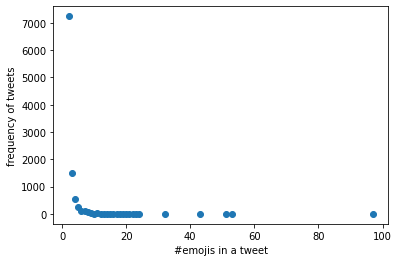

In [15]:
fig, ax = plt.subplots()
ax.plot(emoji_length_distribution.emoji_length, 
        emoji_length_distribution.freq, 
        "o")
ax.set_xlabel("#emojis in a tweet")
ax.set_ylabel("frequency of tweets")

You should see a figure in which the x-axis represents the number of emojis used in a Tweet, and the y-axis represents the number of Tweets that contain that number of emojis. Clearly, we see that most Tweets use only a few (2 or 3) emojis (the dots in the top-left) while a few Tweets use a lot of emojis (the dots in the lower-right). To see the distribution clearly, let's change both the x- and y-axis to log scale.

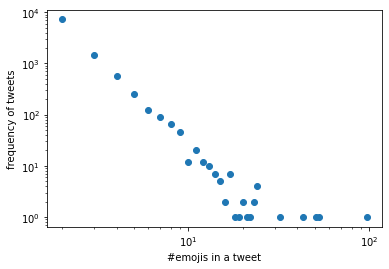

In [16]:
ax.set_xscale("log")
ax.set_yscale("log")
fig

Surprisingly or not, the scatterplot shows a clear trend that is descending linearly. The trend resembles the [power law](https://en.wikipedia.org/wiki/Power_law) distribution, which is commonly observed in large real-world datasets.

Next, let's examine the popularity of individual emojis, that is, the counts and the distribution of single items (emojis). The number of Tweets containing a given emoji can be calculated as the sum of the column in the emoji matrix corresponding to that emoji.

In [17]:
emoji_popularity = emoji_matrix.sum(axis=0)
emoji_popularity.head()

☕    585
🌭    193
🌮    186
🌯     85
🌰     53
dtype: int64

### Exercise 1. Find the most popular emojis (5 pts)
Please compete the `top_n_emojis` function below, which should return a list of the $n$ most popular emojis based on the `emoji_popularity` DataFrame.

In [18]:
# print(type(emoji_popularity))
sorted_vals = list(emoji_popularity.sort_values(ascending=False).index)
# sorted_vals = sorted_vals.to_numpy()
# list(sorted_vals)

def top_n_emojis(n):
#     print(sorted_vals[:n])
    
    return sorted_vals[:n]

assert top_n_emojis(2) == ['🍻', '🎂']

In [19]:
assert top_n_emojis(2) == ['🍻', '🎂']
assert top_n_emojis(5) == ['🍻', '🎂', '🍔', '🍾', '🥂']

The most popular food/drink emojis turn out to be 🍻 and 🎂. Is it a surprise? Maybe they are popular because they mean beyond just beer and cake, but also "cheers" and "happy birthday".